## Notebook 1B: Multivariate regression of energy consumption

**1. Prepare Problem**

In [130]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

In [131]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 8)
   Relative Compactness  Surface Area  Roof Area  Overall Height  Orientation  \
0                  0.98         514.5     110.25             7.0            2   
1                  0.98         514.5     110.25             7.0            3   
2                  0.98         514.5     110.25             7.0            4   
3                  0.98         514.5     110.25             7.0            5   
4                  0.90         563.5     122.50             7.0            2   
5                  0.90         563.5     122.50             7.0            3   
6                  0.90         563.5     122.50             7.0            4   
7                  0.90         563.5     122.50             7.0            5   
8                  0.86         588.0     147.00             7.0            2   
9                  0.86         588.0     147.00             7.0            3   

   Glazing Area  Glazing Area Distribution  Heating Load  
0           0.0                         

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [132]:
# Define features and label
X = data.drop(columns=['Heating Load'], axis = 1)
y = data[['Heating Load']]
print(X.shape, y.shape)

(768, 7) (768, 1)


**2. Dataset summary**

In [133]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Roof Area  Overall Height  \
count               768.000       768.000    768.000         768.000   
mean                  0.764       671.708    176.604           5.250   
std                   0.106        88.086     45.166           1.751   
min                   0.620       514.500    110.250           3.500   
25%                   0.682       606.375    140.875           3.500   
50%                   0.750       673.750    183.750           5.250   
75%                   0.830       741.125    220.500           7.000   
max                   0.980       808.500    220.500           7.000   

       Orientation  Glazing Area  Glazing Area Distribution  Heating Load  
count      768.000       768.000                    768.000       768.000  
mean         3.500         0.234                      2.812        22.307  
std          1.119         0.133                      1.551        10.090  
min          2.000         0.000               

In [134]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

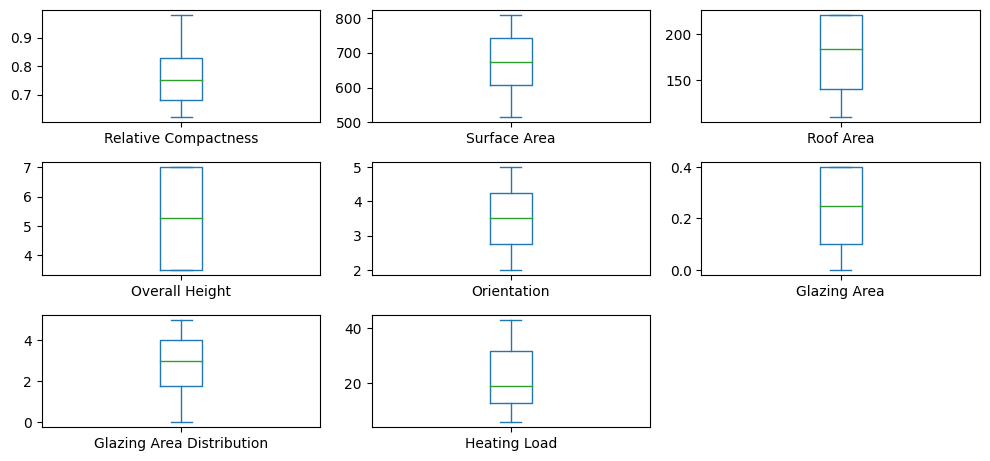

In [135]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

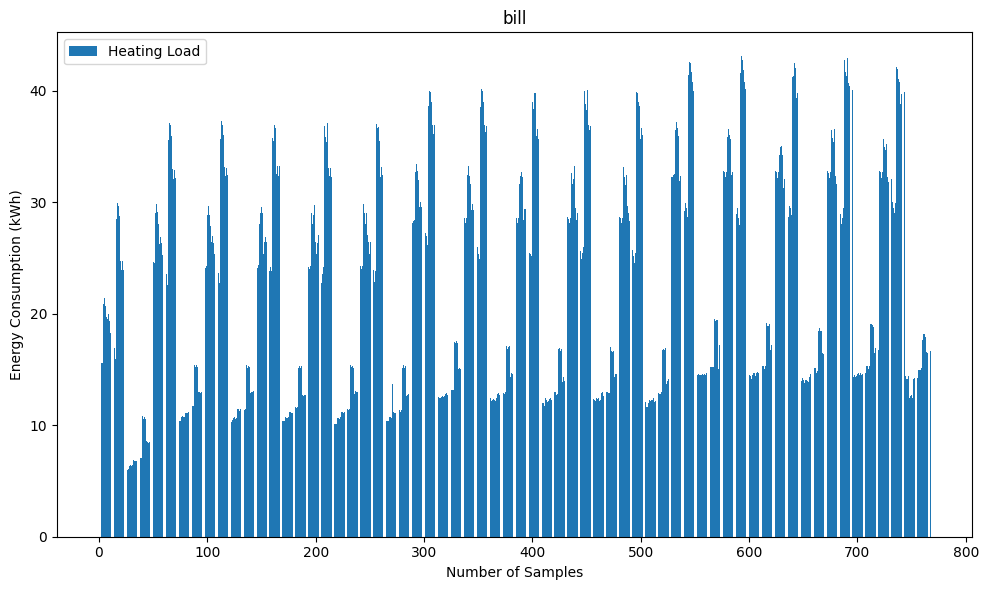

In [136]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('bill')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

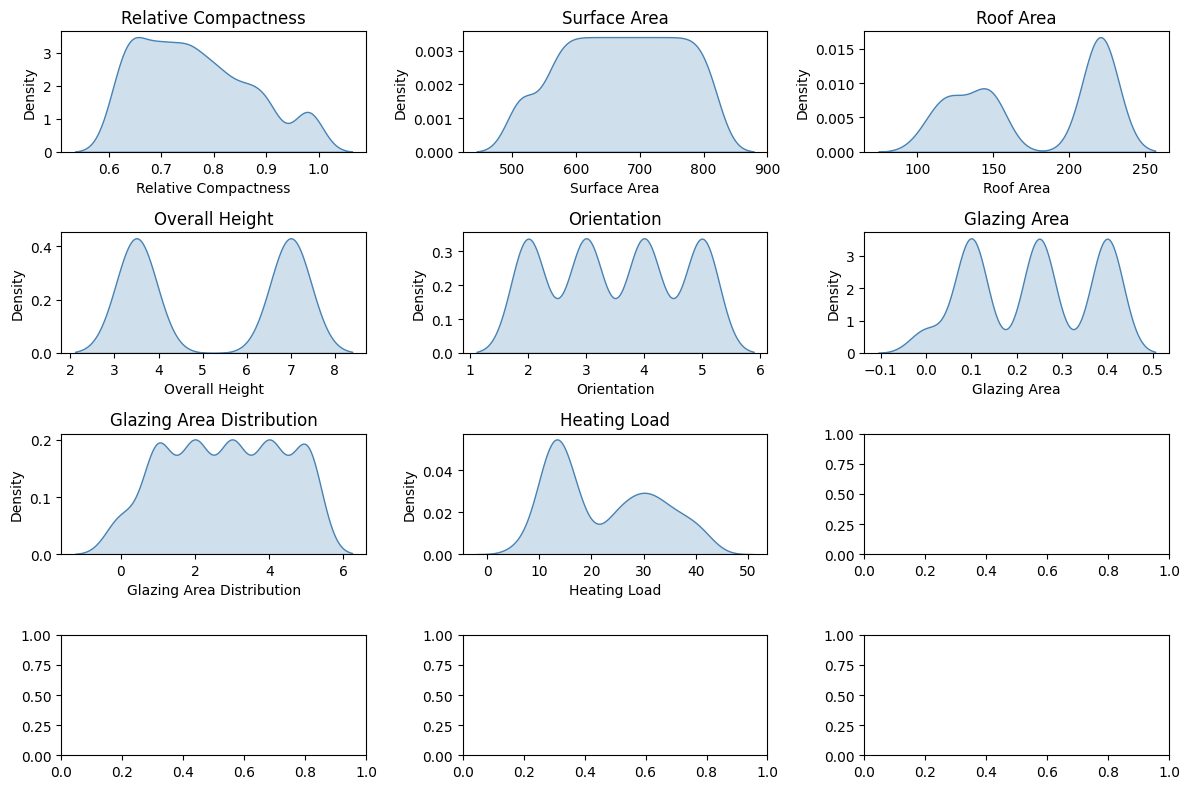

In [137]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array to simplify plotting
axes = axes.flatten()

# Loop through each feature and create a density plot
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', fill=True)
    axes[i].set_title(feature)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

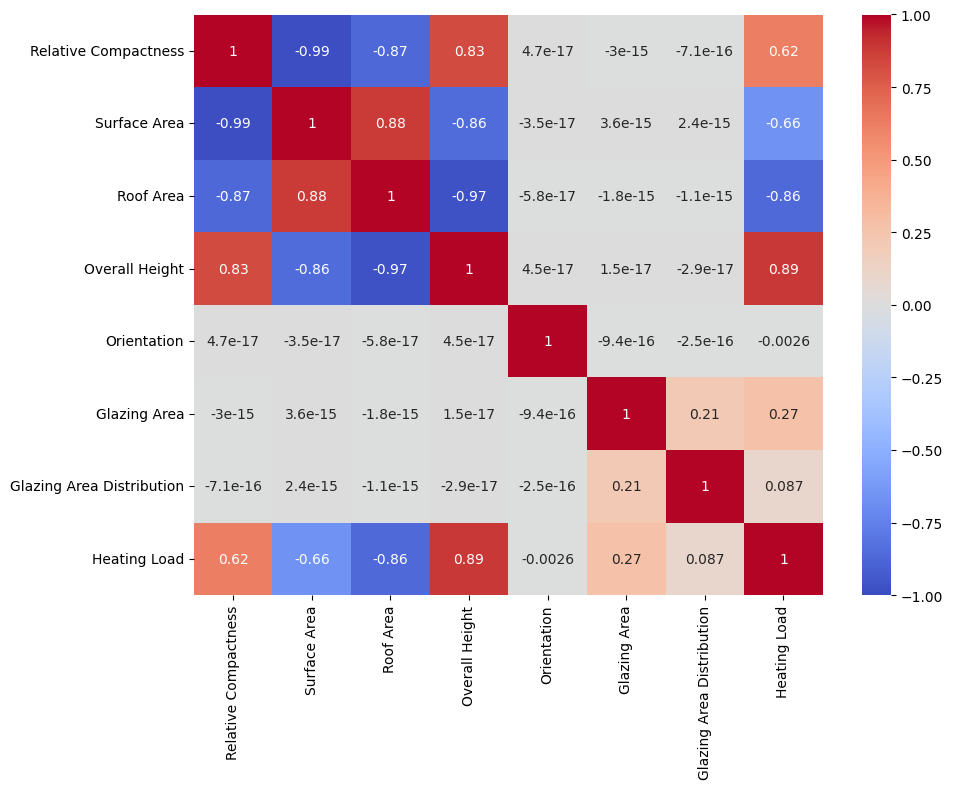

In [138]:
# correlation matrix between all pairs of attributes
corr_matrix = data.corr(method='pearson')

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [139]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
dtype: int64


In [140]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [141]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [142]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [143]:
# b) Split-out dataset into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(576, 7) (576, 1) (192, 7) (192, 1)


In [144]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [145]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 5 most popular linear and tree-based algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', MultiOutputRegressor(SVR(gamma='auto'))))

In [149]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (7, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [150]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [151]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # modify loop for NN
    if name != 'NN':
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:
        validation_data = (X_val, y_val)
        cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})

    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -8.213543 (1.870210)
EN: -48.528127 (10.471758)


c:\Users\Rasin bran 2\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Rasin bran 2\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Rasin bran 2\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Rasin bran 2\.pyenv\pyenv-win\v

RF: -0.372258 (0.171265)
KNN: -9.304752 (2.608518)
SVR: -12.495847 (3.518934)
INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpkvo5wr3f\assets


INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpkvo5wr3f\assets


Epoch 1/150
4/4 [==============================] - 1s 57ms/step - loss: 556.3560 - mse: 556.3560 - val_loss: 637.6707 - val_mse: 637.6707
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 518.6881 - mse: 518.6881 - val_loss: 628.9596 - val_mse: 628.9596
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 500.2209 - mse: 500.2209 - val_loss: 619.6514 - val_mse: 619.6514
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 487.0848 - mse: 487.0848 - val_loss: 610.2917 - val_mse: 610.2917
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 483.3331 - mse: 483.3331 - val_loss: 601.4405 - val_mse: 601.4405
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 479.7166 - mse: 479.7166 - val_loss: 593.0264 - val_mse: 593.0264
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 471.3793 - mse: 471.3793 - val_loss: 585.3830 - val_mse: 585.3830
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmp1ozzhnj_\assets


INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmp1ozzhnj_\assets


Epoch 1/150
4/4 [==============================] - 1s 54ms/step - loss: 574.1360 - mse: 574.1360 - val_loss: 637.8122 - val_mse: 637.8122
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 537.2029 - mse: 537.2029 - val_loss: 629.1540 - val_mse: 629.1540
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 519.1108 - mse: 519.1108 - val_loss: 620.2933 - val_mse: 620.2933
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 508.3862 - mse: 508.3862 - val_loss: 611.6216 - val_mse: 611.6216
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 502.2053 - mse: 502.2053 - val_loss: 602.9022 - val_mse: 602.9022
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 494.9630 - mse: 494.9630 - val_loss: 594.2739 - val_mse: 594.2739
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 490.3383 - mse: 490.3383 - val_loss: 586.2256 - val_mse: 586.2256
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmp94ttgys3\assets


Epoch 1/150
4/4 [==============================] - 1s 59ms/step - loss: 562.6440 - mse: 562.6440 - val_loss: 637.5225 - val_mse: 637.5225
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 526.5263 - mse: 526.5263 - val_loss: 628.8210 - val_mse: 628.8210
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 504.9178 - mse: 504.9178 - val_loss: 619.7863 - val_mse: 619.7863
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 494.7175 - mse: 494.7175 - val_loss: 611.3825 - val_mse: 611.3825
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 493.1639 - mse: 493.1639 - val_loss: 602.9985 - val_mse: 602.9985
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 480.7999 - mse: 480.7999 - val_loss: 594.9015 - val_mse: 594.9015
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 479.7909 - mse: 479.7909 - val_loss: 587.3945 - val_mse: 587.3945
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpv8li7us2\assets


Epoch 1/150
4/4 [==============================] - 1s 53ms/step - loss: 565.8743 - mse: 565.8743 - val_loss: 637.6764 - val_mse: 637.6764
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 531.2817 - mse: 531.2817 - val_loss: 627.9062 - val_mse: 627.9062
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 514.0126 - mse: 514.0126 - val_loss: 618.6974 - val_mse: 618.6974
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 502.6344 - mse: 502.6344 - val_loss: 609.7786 - val_mse: 609.7786
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 496.7378 - mse: 496.7378 - val_loss: 600.8387 - val_mse: 600.8387
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 489.1350 - mse: 489.1350 - val_loss: 592.3846 - val_mse: 592.3846
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 486.8405 - mse: 486.8405 - val_loss: 584.7999 - val_mse: 584.7999
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpjhwofvvp\assets


INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpjhwofvvp\assets


Epoch 1/150
4/4 [==============================] - 1s 54ms/step - loss: 570.7943 - mse: 570.7943 - val_loss: 637.3593 - val_mse: 637.3593
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 528.4889 - mse: 528.4889 - val_loss: 628.9465 - val_mse: 628.9465
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 518.8430 - mse: 518.8430 - val_loss: 620.2053 - val_mse: 620.2053
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 508.1261 - mse: 508.1261 - val_loss: 610.8694 - val_mse: 610.8694
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 499.6569 - mse: 499.6569 - val_loss: 601.8726 - val_mse: 601.8726
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 497.1337 - mse: 497.1337 - val_loss: 594.0734 - val_mse: 594.0734
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 489.0486 - mse: 489.0486 - val_loss: 586.8231 - val_mse: 586.8231
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpfgqqdd2z\assets


Epoch 1/150
4/4 [==============================] - 1s 53ms/step - loss: 556.9084 - mse: 556.9084 - val_loss: 637.8114 - val_mse: 637.8114
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 521.2292 - mse: 521.2292 - val_loss: 628.7884 - val_mse: 628.7884
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 506.1359 - mse: 506.1359 - val_loss: 619.6312 - val_mse: 619.6312
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 494.5953 - mse: 494.5953 - val_loss: 611.1610 - val_mse: 611.1610
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 481.5673 - mse: 481.5673 - val_loss: 602.7354 - val_mse: 602.7354
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 482.1605 - mse: 482.1605 - val_loss: 594.6837 - val_mse: 594.6837
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 479.1358 - mse: 479.1358 - val_loss: 587.1484 - val_mse: 587.1484
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpcqy162ag\assets


Epoch 1/150
4/4 [==============================] - 1s 55ms/step - loss: 574.9329 - mse: 574.9329 - val_loss: 638.2171 - val_mse: 638.2171
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 534.4510 - mse: 534.4510 - val_loss: 629.9822 - val_mse: 629.9822
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 514.2089 - mse: 514.2089 - val_loss: 621.5631 - val_mse: 621.5631
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 512.6219 - mse: 512.6219 - val_loss: 612.2075 - val_mse: 612.2075
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 499.0841 - mse: 499.0841 - val_loss: 602.4876 - val_mse: 602.4876
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 491.0721 - mse: 491.0721 - val_loss: 592.6368 - val_mse: 592.6368
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 487.3571 - mse: 487.3571 - val_loss: 583.3254 - val_mse: 583.3254
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpgplph5n5\assets


INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpgplph5n5\assets


Epoch 1/150
4/4 [==============================] - 1s 55ms/step - loss: 555.6233 - mse: 555.6233 - val_loss: 637.2701 - val_mse: 637.2701
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 515.0361 - mse: 515.0361 - val_loss: 628.4340 - val_mse: 628.4340
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 503.5893 - mse: 503.5893 - val_loss: 619.8727 - val_mse: 619.8727
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 492.0609 - mse: 492.0609 - val_loss: 611.2711 - val_mse: 611.2711
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 487.1117 - mse: 487.1117 - val_loss: 602.9084 - val_mse: 602.9084
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 478.2246 - mse: 478.2246 - val_loss: 594.5600 - val_mse: 594.5600
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 472.9280 - mse: 472.9280 - val_loss: 586.7661 - val_mse: 586.7661
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpdsgulz0z\assets


Epoch 1/150
4/4 [==============================] - 1s 53ms/step - loss: 550.3384 - mse: 550.3384 - val_loss: 637.4922 - val_mse: 637.4922
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 520.3655 - mse: 520.3655 - val_loss: 628.4912 - val_mse: 628.4912
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 503.6381 - mse: 503.6381 - val_loss: 619.9921 - val_mse: 619.9921
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 493.5739 - mse: 493.5739 - val_loss: 611.3332 - val_mse: 611.3332
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 484.9407 - mse: 484.9407 - val_loss: 602.3349 - val_mse: 602.3349
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 478.2306 - mse: 478.2306 - val_loss: 593.2115 - val_mse: 593.2115
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 473.3109 - mse: 473.3109 - val_loss: 584.6284 - val_mse: 584.6284
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpaofcta0g\assets


Epoch 1/150
4/4 [==============================] - 1s 54ms/step - loss: 574.6948 - mse: 574.6948 - val_loss: 637.7798 - val_mse: 637.7798
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 535.1520 - mse: 535.1520 - val_loss: 629.6804 - val_mse: 629.6804
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 517.2974 - mse: 517.2974 - val_loss: 620.9788 - val_mse: 620.9788
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 507.2374 - mse: 507.2374 - val_loss: 611.7240 - val_mse: 611.7240
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 502.7112 - mse: 502.7112 - val_loss: 602.4413 - val_mse: 602.4413
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 497.8417 - mse: 497.8417 - val_loss: 593.1082 - val_mse: 593.1082
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 496.5164 - mse: 496.5164 - val_loss: 584.8962 - val_mse: 584.8962
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpty6n0ngh\assets


Epoch 1/150
4/4 [==============================] - 1s 54ms/step - loss: 558.2881 - mse: 558.2881 - val_loss: 637.4766 - val_mse: 637.4766
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 523.7928 - mse: 523.7928 - val_loss: 629.2795 - val_mse: 629.2795
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 509.2341 - mse: 509.2341 - val_loss: 621.5108 - val_mse: 621.5108
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 498.8575 - mse: 498.8575 - val_loss: 613.2986 - val_mse: 613.2986
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 490.5196 - mse: 490.5196 - val_loss: 604.7838 - val_mse: 604.7838
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 484.6989 - mse: 484.6989 - val_loss: 596.3741 - val_mse: 596.3741
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 479.7836 - mse: 479.7836 - val_loss: 588.2123 - val_mse: 588.2123
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmppfr81lln\assets


Epoch 1/150
4/4 [==============================] - 1s 55ms/step - loss: 567.0153 - mse: 567.0153 - val_loss: 637.8137 - val_mse: 637.8137
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 532.5348 - mse: 532.5348 - val_loss: 629.2365 - val_mse: 629.2365
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 511.7562 - mse: 511.7562 - val_loss: 620.7820 - val_mse: 620.7820
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 498.7715 - mse: 498.7715 - val_loss: 611.7290 - val_mse: 611.7290
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 499.1779 - mse: 499.1779 - val_loss: 602.1297 - val_mse: 602.1297
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 491.3260 - mse: 491.3260 - val_loss: 593.0831 - val_mse: 593.0831
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 487.9046 - mse: 487.9046 - val_loss: 584.0887 - val_mse: 584.0887
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmp69w_vjk_\assets


Epoch 1/150
4/4 [==============================] - 1s 55ms/step - loss: 570.2070 - mse: 570.2070 - val_loss: 637.1487 - val_mse: 637.1487
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 532.0078 - mse: 532.0078 - val_loss: 628.4344 - val_mse: 628.4344
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 521.0391 - mse: 521.0391 - val_loss: 619.8985 - val_mse: 619.8985
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 509.3294 - mse: 509.3294 - val_loss: 611.0897 - val_mse: 611.0897
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 501.9236 - mse: 501.9236 - val_loss: 602.2904 - val_mse: 602.2904
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 496.1886 - mse: 496.1886 - val_loss: 593.3289 - val_mse: 593.3289
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 493.2678 - mse: 493.2678 - val_loss: 584.9045 - val_mse: 584.9045
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmph_d85p7q\assets


Epoch 1/150
4/4 [==============================] - 1s 52ms/step - loss: 554.8678 - mse: 554.8678 - val_loss: 637.1074 - val_mse: 637.1074
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 520.2299 - mse: 520.2299 - val_loss: 628.5362 - val_mse: 628.5362
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 501.7063 - mse: 501.7063 - val_loss: 619.8542 - val_mse: 619.8542
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 493.7349 - mse: 493.7349 - val_loss: 611.3799 - val_mse: 611.3799
Epoch 5/150
4/4 [==============================] - 0s 14ms/step - loss: 487.6741 - mse: 487.6741 - val_loss: 602.8416 - val_mse: 602.8416
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 480.5655 - mse: 480.5655 - val_loss: 594.9290 - val_mse: 594.9290
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 478.2646 - mse: 478.2646 - val_loss: 587.2033 - val_mse: 587.2033
Epoch 8/150
4/4 [=================

4/4 [==============================] - 1s 186ms/step - loss: 36.4919 - mse: 36.4919 - val_loss: 42.4139 - val_mse: 42.4139
Epoch 95/150
4/4 [==============================] - 0s 15ms/step - loss: 41.4087 - mse: 41.4087 - val_loss: 39.9772 - val_mse: 39.9772
Epoch 96/150
4/4 [==============================] - 0s 14ms/step - loss: 34.2068 - mse: 34.2068 - val_loss: 37.5793 - val_mse: 37.5793
Epoch 97/150
4/4 [==============================] - 0s 15ms/step - loss: 31.5861 - mse: 31.5861 - val_loss: 35.2751 - val_mse: 35.2751
Epoch 98/150
4/4 [==============================] - 0s 14ms/step - loss: 38.6347 - mse: 38.6347 - val_loss: 33.4436 - val_mse: 33.4436
Epoch 99/150
4/4 [==============================] - 0s 15ms/step - loss: 30.5062 - mse: 30.5062 - val_loss: 31.6588 - val_mse: 31.6588
Epoch 100/150
4/4 [==============================] - 0s 14ms/step - loss: 32.5933 - mse: 32.5933 - val_loss: 29.0908 - val_mse: 29.0908
Epoch 101/150
4/4 [==============================] - 0s 16ms/step 

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmpqwykya23\assets


Epoch 1/150
4/4 [==============================] - 1s 53ms/step - loss: 570.7810 - mse: 570.7810 - val_loss: 637.5963 - val_mse: 637.5963
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 536.7318 - mse: 536.7318 - val_loss: 628.7664 - val_mse: 628.7664
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 514.0783 - mse: 514.0783 - val_loss: 620.3495 - val_mse: 620.3495
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 507.9802 - mse: 507.9802 - val_loss: 612.0743 - val_mse: 612.0743
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 501.4948 - mse: 501.4948 - val_loss: 603.9688 - val_mse: 603.9688
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 491.3306 - mse: 491.3306 - val_loss: 596.2109 - val_mse: 596.2109
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 485.5358 - mse: 485.5358 - val_loss: 588.3775 - val_mse: 588.3775
Epoch 8/150
4/4 [=================

INFO:tensorflow:Assets written to: C:\Users\RASINB~1\AppData\Local\Temp\tmp487hb_s_\assets


Epoch 1/150
4/4 [==============================] - 1s 58ms/step - loss: 554.0363 - mse: 554.0363 - val_loss: 637.5772 - val_mse: 637.5772
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 522.0802 - mse: 522.0802 - val_loss: 628.5759 - val_mse: 628.5759
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 498.1251 - mse: 498.1251 - val_loss: 620.0104 - val_mse: 620.0104
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 490.5361 - mse: 490.5361 - val_loss: 611.4451 - val_mse: 611.4451
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 481.8044 - mse: 481.8044 - val_loss: 602.8503 - val_mse: 602.8503
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 476.6422 - mse: 476.6422 - val_loss: 594.0139 - val_mse: 594.0139
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 469.1562 - mse: 469.1562 - val_loss: 585.8821 - val_mse: 585.8821
Epoch 8/150
4/4 [=================

Epoch 1/500
5/5 [==============================] - 1s 46ms/step - loss: 559.8362 - mse: 559.8362 - val_loss: 635.3430 - val_mse: 635.3430
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 522.2365 - mse: 522.2365 - val_loss: 624.6725 - val_mse: 624.6725
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 507.3412 - mse: 507.3412 - val_loss: 614.8991 - val_mse: 614.8991
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 493.5118 - mse: 493.5118 - val_loss: 605.0456 - val_mse: 605.0456
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 491.3497 - mse: 491.3497 - val_loss: 595.0359 - val_mse: 595.0359
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 478.7591 - mse: 478.7591 - val_loss: 585.7885 - val_mse: 585.7885
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 476.6585 - mse: 476.6585 - val_loss: 577.9932 - val_mse: 577.9932
Epoch 8/500
5/5 [=================

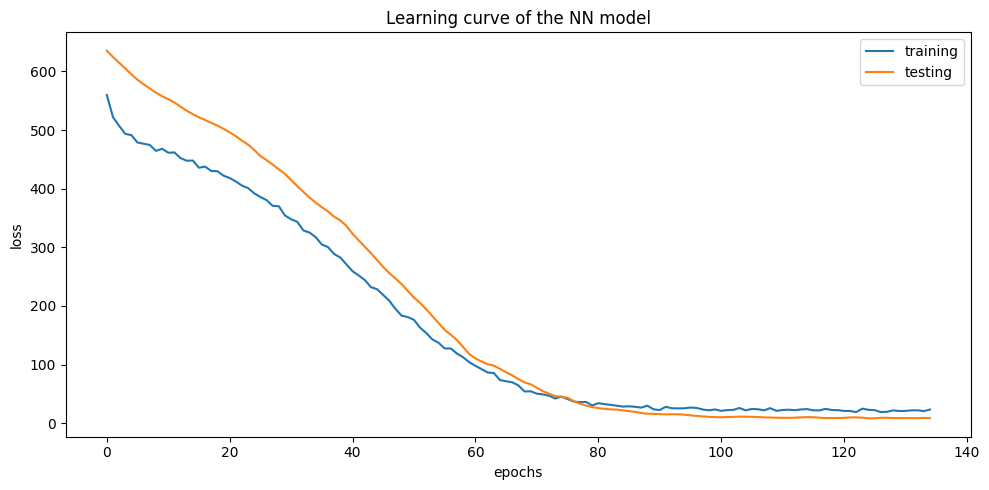

In [152]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

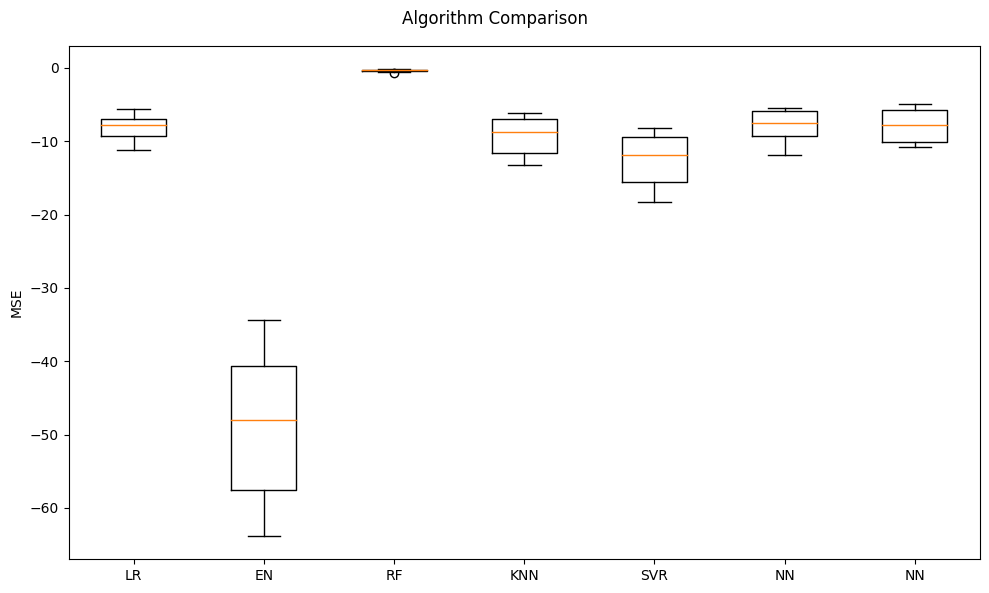

In [153]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

The Random Forest algorithm demonstrated superior performance compared to the other five machine learning algorithms and the neural network model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [154]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  0.375170833333333


C:\Users\Rasin bran 2\AppData\Local\Temp\ipykernel_36516\3872500001.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RF.fit(X_train, y_train)


In [155]:
# Evaluate performance of NN algorithm on validation data
model_NN.fit(X_train, y_train)
y_pred_NN = model_NN.predict(X_val)
print(y_pred_NN.shape)
mae_pred_NN = mean_absolute_error(y_val, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

6/6 [==============================] - 0s 2ms/step
(192, 1)
Mean Absolute Error of predicted data:  2.0763323688507076


In [156]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  9.156708306206598


The resulting MAE values show that Random Forest looks better than neural network model in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the multi-objective optimization process.

**5. Finalize Model**

In [157]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


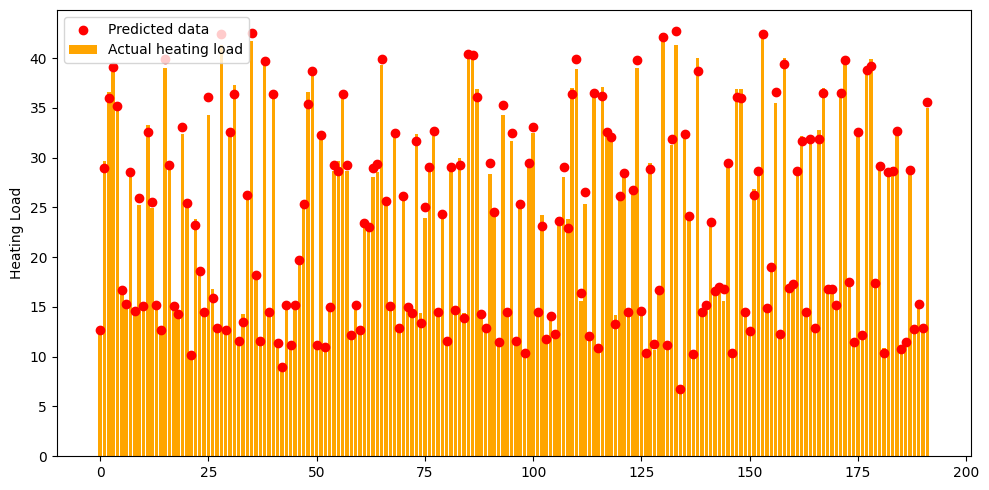

In [158]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the actual and predicted heating load
ax.bar(np.arange(len(y_val)), y_val.iloc[:, 0], label='Actual heating load', color='orange')
ax.scatter(np.arange(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')
ax.set_ylabel('Heating Load')
ax.legend()

# Show the plot
plt.show()



In [159]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model_multivariate.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis indicates that most input variables exhibit non-Gaussian distribution.

- Based on our evaluation of five machine learning algorithms and a neural network model, we selected Random Forest as the surrogate model for multi-objective optimization due to its high score in cross validation and low Mean Squared Error values.

- The Mean Absolute Error values suggest that the prediction accuracy is generally good, although the ElasticNet algorithm may require further refinement.

- The results indicate that the performance of the Keras Sequential neural network model is comparable to that of other machine learning algorithms, and further hyperparameter tuning may improve its predictive accuracy.